In [1]:
import h5py, sys, os
import numpy as np
from scipy import ndimage
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation
from datetime import datetime
from matplotlib import colors
print(os.getcwd())

# PyDMD imports
from pydmd import DMD, MrDMD, FbDMD, SpDMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D, plot_eigs_mrdmd

%matplotlib widget

save = False
plotting = True

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/waves


In [2]:
print(base_dir)

#Load simulation data
u, w, b, phi, zeta, times = load_data('u_xz', 'w_xz', 'th1_xz', 'th2_xz', 'omegaY_xz')
N2t = np.gradient(np.gradient(b, gzf, axis=1), times, axis=0)
b -= b[0] # subtract initial profile so b is perturbation b
NSAMP = len(times)

print(w.shape)

times, t0_idx = calibrate_time(save_dir, times)

/store/ATMOS/cwp29/data/waves/wide/hres/N_1/
Keys: <KeysViewHDF5 ['epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'nlwf_xz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'u_xy', 'u_xz', 'u_yz', 'v_xy', 'v_xz', 'v_yz', 'w_xy', 'w_xz', 'w_yz']>


/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/alt/applic/user-maint/cwp29/Conda/envs/python/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


(156, 513, 1024)
Plume penetration occured at t=2.3545


In [3]:
buoy_per = round(2*np.pi/np.sqrt(md['N2']),1)
md['TIME_LIMIT'] = (md['FINE_RES_TIME'] + md['NBUOY_PERIODS'])*buoy_per
md['SAVE_STATS_DT'] *= buoy_per
md['SAVE_STATS_DT_FINE'] *= buoy_per
tend_idx = len(times)-1
tstart_idx = get_index(md['FINE_RES_TIME']*buoy_per, times)
print(md['TIME_LIMIT'], md['FINE_RES_TIME']*buoy_per)
print("Time range: {0:.2f} to {1:.2f} s".format(times[tstart_idx], times[tend_idx]))
print("equal to {0:.2f} buoyancy periods".format((times[tend_idx]-times[tstart_idx])/buoy_per))

# characteristic spectra
omega_c = 0.39
k_xc = 23.9

N = np.sqrt(md['N2'])

#zplot = 0.4
zmin = 0.2
zmax = 0.45
zmin_idx = get_index(zmin, gzf)
zmax_idx = get_index(zmax, gzf)
gz_trunc = gz[zmin_idx-1:zmax_idx+2]
gzf_trunc = gzf[zmin_idx-1:zmax_idx+1]

xmin = 0.3
xmax = 0.7
xlims = (xmin, xmax)
xmin_idx = get_index(xmin, gxf)
xmax_idx = get_index(xmax, gxf)
gx_trunc = gx[zmin_idx-1:zmax_idx+2]
gxf_trunc = gxf[zmin_idx-1:zmax_idx+1]

phi_contour = 1e-3
clim = 1e-3

# Choose data window
u = u[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
w = w[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
b = b[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
zeta = zeta[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
N2t = N2t[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
phi = phi[tstart_idx:tend_idx+1, zmin_idx:zmax_idx+1, xmin_idx:xmax_idx+1]
times = times[tstart_idx:tend_idx+1]

# Filter out timesteps
filter_step = 1
times = times[::filter_step]
times_trunc = np.concatenate(([times[0]-filter_step*md['SAVE_STATS_DT_FINE']], times))
ntimes = len(times)

print(len(times))

phi_snapshots = [phi[::filter_step][i] for i in range(len(times))]

X, Y = np.meshgrid(gx[xmin_idx-1:xmax_idx+1], gz[zmin_idx-1:zmax_idx+1])
Xf, Yf = np.meshgrid(gxf[xmin_idx:xmax_idx+1], gzf[zmin_idx:zmax_idx+1])

gxf_trunc = gxf[xmin_idx:xmax_idx+1]
gzf_trunc = gzf[zmin_idx:zmax_idx+1]

25.2 6.3
Time range: 6.30 to 25.07 s
equal to 2.98 buoyancy periods
150


In [5]:
# Pre-processing & data array setup
data_pack = [u, w, N2t, zeta]
data_orig = np.array(data_pack)
data_orig = np.moveaxis(data_orig, 0, -1)

plot_idx = 1

wavenumber_z = np.fft.fftfreq(w.shape[1])*2*np.pi*md['Nz']/md['LZ']
wavenumber_x = np.fft.fftfreq(w.shape[2])*2*np.pi*md['Nx']/md['LX']

for i in range(len(data_pack)):
    var = data_pack[i]
    
    # Gaussian filtering
    sigma = 2
    var_filtered = np.zeros_like(var)
    for j in range(len(var)):
        var_filtered[j] = ndimage.gaussian_filter(var[j], sigma)

    # Hilbert transform
    # Dimension sizes from large to small: x, z, t

    # FFT in x
    waves_x = np.fft.fft(var_filtered, axis=2)
    waves_x[:, :, np.abs(wavenumber_x) >= 1000] = 0 #remove small wavelength oscillations
    waves_filtered = np.fft.ifft(waves_x, axis=2)

    # FFT in z
    waves_z = np.fft.fft(waves_filtered, axis=1)
    #waves_z[:, wavenumber_z >= 0, :] = 0 #remove upward propagating waves
    waves_filtered = np.fft.ifft(waves_z, axis=1)
    
    waves_t = np.fft.fft(waves_filtered, axis=0)
    #waves_t[freq_m <= 0, :, :] = 0 # zero out negative freq.
    #waves_t *= 2 # preserve energy
    waves_filtered = np.real(np.fft.ifft(waves_t, axis=0))

    data_pack[i] = waves_filtered

data = np.array(data_pack)
print(data.shape)
data = np.moveaxis(data, 0, -1)
print(data.shape)

#data = np.concatenate(tuple(data_pack), axis=1)
#print(data_pack[0].shape, data.shape)
#unpacked_data = np.array_split(data, len(data_pack), axis=1)

(4, 150, 214, 410)
(150, 214, 410, 4)


Text(0.5, 0, '$\\omega/N$')

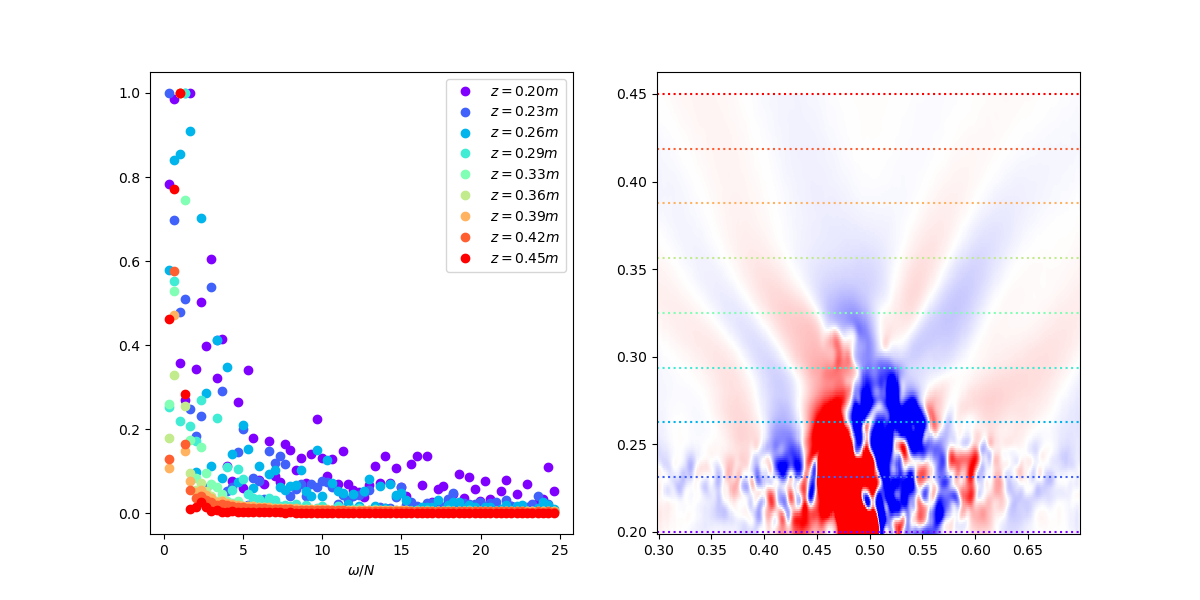

In [12]:
heights = np.linspace(zmin, zmax, 5)
var = data[:,:,:,1]
var -= np.mean(var, axis=0) # extract perturbation value

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#im = ax[1].pcolormesh(X, Y, np.mean(var, axis=0), cmap='bwr', norm=colors.CenteredNorm())
im = ax[1].pcolormesh(X, Y, var[-1], cmap='bwr', norm=colors.CenteredNorm())
im.set_clim(-1e-2, 1e-2)

cols = plt.cm.rainbow(np.linspace(0, 1, len(heights)))

for z, c in zip(heights, cols):
    z_idx = get_index(z, gzf_trunc)

    time_series = var[:, z_idx, :]

    spectrum = np.mean(np.fft.fft(time_series, axis=0), axis=1)
    
    freq = np.fft.fftfreq(tend_idx-tstart_idx+1)*2*np.pi/md['SAVE_STATS_DT_FINE']

    ax[0].plot(freq[freq > 0]/N, np.abs(spectrum[freq > 0])/np.max(np.abs(spectrum[freq>0])), "o", label=r"$z={0:.2f} m$".format(z), color=c)
    ax[1].axhline(z, linestyle=':', color=c)

ax[0].legend()
ax[0].set_xlabel(r"$\omega/N$")